In [1]:
import pandas as pd
import numpy as np
import json
from scipy.stats import entropy
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm_joblib import tqdm_joblib
from tqdm import tqdm
from itertools import product
from joblib import Parallel, delayed
from scipy.optimize import minimize
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from scipy.optimize import NonlinearConstraint
import warnings
import pickle
import math
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',category=UserWarning, module='scipy')

/usr/local/Caskroom/miniforge/base/envs/gpt2/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dfs = ['bank', 'credit', 'iranian', 'telco']
n = 0
def read_and_clip(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    numeric_cols = df.select_dtypes(include=['number'])
    non_numeric_cols = df.select_dtypes(exclude=['number']) 
    numeric_cols = numeric_cols.clip(lower=0)
    if 'Gender' in numeric_cols.columns:
        numeric_cols['Gender'] = numeric_cols['Gender'].clip(upper=1)
    if 'gender_Male' in numeric_cols.columns:
        numeric_cols['gender_Male'] = numeric_cols['gender_Male'].clip(upper=1)
    return pd.concat([numeric_cols, non_numeric_cols], axis=1)

In [3]:
#Import Datasets
df_bank_real = pd.read_csv("original datasets/df2_clean.csv", index_col=0)
df_credit_real = pd.read_csv("original datasets/df3_clean.csv", index_col=0)
df_iranian_real = pd.read_csv("original datasets/df4_clean.csv", index_col=0)
df_telco_real = pd.read_csv("original datasets/df5_clean.csv", index_col=0)

df_bank_synth = pd.read_csv("synth datasets/Dataset_1_CTGAN_synthetic.csv")
df_credit_synth = pd.read_csv("synth datasets/Dataset_2_CTGAN_synthetic.csv")
df_iranian_synth = pd.read_csv("synth datasets/Dataset_3_CTGAN_synthetic.csv")
df_telco_synth = pd.read_csv("synth datasets/Dataset_4_CTGAN_synthetic.csv")

df_bank_real_0 = df_bank_real[df_bank_real['churn'] == 0].drop(columns='churn', axis=1)
df_bank_real_1 = df_bank_real[df_bank_real['churn'] == 1].drop(columns='churn', axis=1)

df_bank_synth_0 = df_bank_synth[df_bank_synth['churn'] == 0].drop(columns='churn', axis=1)
df_bank_synth_1 = df_bank_synth[df_bank_synth['churn'] == 1].drop(columns='churn', axis=1)

df_credit_real_0 = df_credit_real[df_credit_real['churn'] == 0].drop(columns='churn', axis=1)
df_credit_real_1 = df_credit_real[df_credit_real['churn'] == 1].drop(columns='churn', axis=1)

df_credit_synth_0 = df_credit_synth[df_credit_synth['churn'] == 0].drop(columns='churn', axis=1)
df_credit_synth_1 = df_credit_synth[df_credit_synth['churn'] == 1].drop(columns='churn', axis=1)

df_iranian_real_0 = df_iranian_real[df_iranian_real['churn'] == 0].drop(columns='churn', axis=1)
df_iranian_real_1 = df_iranian_real[df_iranian_real['churn'] == 1].drop(columns='churn', axis=1)

df_iranian_synth_0 = df_iranian_synth[df_iranian_synth['churn'] == 0].drop(columns='churn', axis=1)
df_iranian_synth_1 = df_iranian_synth[df_iranian_synth['churn'] == 1].drop(columns='churn', axis=1)

df_telco_real_0 = df_telco_real[df_telco_real['churn'] == 0].drop(columns='churn', axis=1)
df_telco_real_1 = df_telco_real[df_telco_real['churn'] == 1].drop(columns='churn', axis=1)

df_telco_synth_0 = df_telco_synth[df_telco_synth['churn'] == 0].drop(columns='churn', axis=1)
df_telco_synth_1 = df_telco_synth[df_telco_synth['churn'] == 1].drop(columns='churn', axis=1)

In [4]:
# Import CF Explanations
ensemble_df_bank_synth = read_and_clip(f'synth ensembles/ensemble_df_synth_{dfs[0]}.csv')
ensemble_df_bank_real = read_and_clip(f'original ensembles/ensemble_df_new_{dfs[0]}.csv')

ensemble_df_credit_synth = read_and_clip(f'synth ensembles/ensemble_df_synth_{dfs[1]}.csv')
ensemble_df_credit_real = read_and_clip(f'original ensembles/ensemble_df_new_{dfs[1]}.csv')

ensemble_df_iranian_synth = read_and_clip(f'synth ensembles/ensemble_df_synth_{dfs[2]}.csv')
ensemble_df_iranian_real = read_and_clip(f'original ensembles/ensemble_df_new_{dfs[2]}.csv')

ensemble_df_telco_synth = read_and_clip(f'synth ensembles/ensemble_df_synth_{dfs[3]}.csv')
ensemble_df_telco_real = read_and_clip(f'original ensembles/ensemble_df_new_{dfs[3]}.csv')

# Apply to real ensemble datasets
ensemble_df_bank_real['Opp_Diversity_Normalized'] = 1. - ensemble_df_bank_real['Diversity_Normalized']
ensemble_df_credit_real['Opp_Diversity_Normalized'] = 1. - ensemble_df_credit_real['Diversity_Normalized']
ensemble_df_iranian_real['Opp_Diversity_Normalized'] = 1. - ensemble_df_iranian_real['Diversity_Normalized']
ensemble_df_telco_real['Opp_Diversity_Normalized'] = 1. - ensemble_df_telco_real['Diversity_Normalized']

# Apply to synthetic ensemble datasets
ensemble_df_bank_synth['Opp_Diversity_Normalized'] = 1. - ensemble_df_bank_synth['Diversity_Normalized']
ensemble_df_credit_synth['Opp_Diversity_Normalized'] = 1. - ensemble_df_credit_synth['Diversity_Normalized']
ensemble_df_iranian_synth['Opp_Diversity_Normalized'] = 1. - ensemble_df_iranian_synth['Diversity_Normalized']
ensemble_df_telco_synth['Opp_Diversity_Normalized'] = 1. - ensemble_df_telco_synth['Diversity_Normalized']

In [28]:
cf_measures = ['Sparsity', 'Pausibility_Normalized', 'AVG_Proximity', 'Opp_Diversity_Normalized']

def linear_selection(df, weights):    
    df_copy = df.copy()

    # Compute the linear combination score
    df_copy['Linear Combination'] = (
        weights[0] * df_copy[cf_measures[0]] +
        weights[1] * df_copy[cf_measures[1]] +
        weights[2] * df_copy[cf_measures[2]] +
        weights[3] * df_copy[cf_measures[3]])

    # Sort the DataFrame by 'Linear Combination' in asc order: ### The lower the score the better ###
    df_copy_sorted = df_copy.sort_values(by='Linear Combination', ascending=True)

    # Group by index and select the top 5 rows for each group
    top_5_per_index = df_copy_sorted.groupby(level=0).head(5)
    # Sort it 
    top_5_per_index_sorted = top_5_per_index.sort_index()
    return top_5_per_index_sorted

In [ ]:
def pseudo_hierarchical_selection(df, cf_measures, weights, k_selected):
    """
    Perform hierarchical selection based on precomputed metrics,
    ordering the metrics by weights (higher values are better)
    """
    df_copy = df.copy()
    
    # Sort metrics in order according to weights importance (higher weights are better)
    sorted_metrics = [cf_measures[i] for i in np.argsort(weights)[::-1]]
    sorted_weights = np.sort(weights)[::-1]
 
    top_k = pd.DataFrame()
 
    for metric, weight in zip(sorted_metrics, sorted_weights):
        #proportion = int(k_selected * weight) #  # marzio original version ((may end up selecting less than 5 at finish)
        proportion = math.ceil(k_selected * weight) # # maybe better version (may end up selecting more than 5 before finish)
        #print(f"Selecting {proportion} samples based on {metric}")
        # Save the selected proportion of examples for each level=0
        selected_proportion_df = df_copy.sort_values(by=metric, ascending=False).groupby(level=0).head(proportion)
        #print("Selected proportion df:\n", selected_proportion_df.shape, proportion * len(df_copy.groupby(level=0)))
 
        top_k = pd.concat([top_k, selected_proportion_df])
        #print(len(top_k),len(selected_proportion_df),df_copy.shape)
        #df_copy = df_copy[~df_copy.apply(tuple, 1).isin(selected_proportion_df.apply(tuple, 1))]
        #print(df_copy.shape, 'shape of df_copy after dropping selected')
    
        
    # If we have more than k_selected, we trim the excess
    #print('length of top k', len(top_k), 'with respect to k_selected', k_selected * len(df.groupby(level=0)))
    top_k = top_k.groupby(level=0).head(k_selected)
    
    
    return top_k

### Minimization 

In [29]:
synth_df = read_and_clip(f'synth ensembles/ensemble_df_synth_{dfs[n]}.csv')
real_df = read_and_clip(f'original ensembles/ensemble_df_new_{dfs[n]}.csv')

In [30]:
if n==0:    #1) df_bank
    cat_cols= ['Gender']
    cont_cols_to_bin = real_df.columns[[0]].tolist() + real_df.columns[2:-6].tolist()
elif n==1:  #2) df_credit
    cat_cols= ['Gender']   
    cont_cols_to_bin = real_df.columns[[0]].tolist() + real_df.columns[2:-6].tolist()
elif n==2:  #3) df_iranian
    cat_cols= []
    cont_cols_to_bin = real_df.columns[:-6].tolist()
else:   #4) df_telco
    cat_cols= ['gender_Male']
    cont_cols_to_bin = [i for i in real_df.columns[:-6] if i!='gender_Male']
print('cat cols: ', cat_cols)
print('cont_cols_to_bin: ', cont_cols_to_bin)

cat cols:  ['Gender']
cont_cols_to_bin:  ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [31]:
def compute_kl_divergence(posterior_df, prior_df, cat_cols, cont_cols, bins='sturges',epsilon=1e-10):
    # Rename variables
    kl_values = {}
    
    for col in cont_cols:    # Continuous columns
        # Determine the number of bins
        if bins == 'sturges':
            bins = max(3, int(np.ceil(np.log2(len(posterior_df[col])) + 1)))

        # Bin continuous data
        posterior_hist, bin_edges = np.histogram(posterior_df[col], bins=bins, density=True)
        prior_hist, _ = np.histogram(prior_df[col], bins=bin_edges, density=True)

        # Normalize histograms to get probability distributions
        posterior_prob = posterior_hist / posterior_hist.sum()
        prior_prob = prior_hist / prior_hist.sum()

        # Avoid zeros
        posterior_prob = np.where(posterior_prob == 0, epsilon, posterior_prob)
        prior_prob = np.where(prior_prob == 0, epsilon, prior_prob)

        # Compute KL Divergence
        kl_values[col] = np.sum(posterior_prob * np.log(posterior_prob / prior_prob))
        

    for col in cat_cols:
        # Compute category probabilities
        posterior_counts = posterior_df[col].value_counts(normalize=True).sort_index()
        prior_counts = prior_df[col].value_counts(normalize=True).sort_index()

        # Align categories 
        all_categories = set(posterior_counts.index).union(set(prior_counts.index))
        posterior_prob = np.array([posterior_counts.get(cat, epsilon) for cat in all_categories])
        prior_prob = np.array([prior_counts.get(cat, epsilon) for cat in all_categories])

        # Must normalize to ensure sum = 1 in case of added epsilon
        posterior_prob /= posterior_prob.sum()
        prior_prob /= prior_prob.sum()

        # Compute KL Divergence
        kl_values[col] = np.sum(posterior_prob * np.log(posterior_prob / prior_prob))
    avg_kl_divergence = np.mean(list(kl_values.values()))
    return avg_kl_divergence

# Compute KL Divergence
avg_kl_divergence = compute_kl_divergence(synth_df,real_df,cat_cols,cont_cols_to_bin, bins='sturges',epsilon=1e-10)

'''print('\nIndividual KL Divergences:')
for col, kl in kl_values.items():
    print(f'{col}: {kl:.4f}')'''

print(f'\nAverage KL Divergence before selection: {avg_kl_divergence:.4f}')


Average KL Divergence before selection: 0.1927


In [32]:
def loss_kl_divergence(parameters,posterior_df,prior_df,cat_cols,cont_cols, 
                       k_selected = 5, 
                       cf_measures = ['Sparsity', 'Pausibility_Normalized', 'AVG_Proximity', 'Opp_Diversity_Normalized'], 
                       bins='sturges', epsilon=1e-10):
    
    n_parameters = len(cf_measures)
    # Extract the parameters
    alpha = parameters[:n_parameters]
    beta = parameters[n_parameters:]

    posterior_df_copy = posterior_df.copy()
    posterior_df_copy['Linear Combination'] = (
        alpha[0] * posterior_df[cf_measures[0]] +
        alpha[1] * posterior_df[cf_measures[1]] +
        alpha[2] * posterior_df[cf_measures[2]] +
        alpha[3] * posterior_df[cf_measures[3]]
    )

    prior_df_copy = prior_df.copy()
    prior_df_copy['Linear Combination'] = (
        beta[0] * prior_df[cf_measures[0]] +
        beta[1] * prior_df[cf_measures[1]] +
        beta[2] * prior_df[cf_measures[2]] +
        beta[3] * prior_df[cf_measures[3]]
    )
    
    posterior_df_copy = posterior_df_copy.sort_values(by='Linear Combination', ascending=True)
    prior_df_copy = prior_df_copy.sort_values(by='Linear Combination', ascending=True)

    top_k_posterior = posterior_df_copy.groupby(level=0).head(k_selected)
    top_k_prior = prior_df_copy.groupby(level=0).head(k_selected)
    
    # Compute the KL Divergence between top_k_posterior and top_k_prior
    avg_kl_divergence = compute_kl_divergence(top_k_posterior,top_k_prior,cat_cols,cont_cols,bins,epsilon)
    return avg_kl_divergence

In [33]:
cf_measures = ['Sparsity', 'Pausibility_Normalized', 'AVG_Proximity', 'Opp_Diversity_Normalized']

def constraint_func(x, num_features):
    alpha_sum = np.sum(x[:num_features]) - 1
    beta_sum = np.sum(x[num_features:]) - 1
    return np.array([alpha_sum, beta_sum])

num_features = len(cf_measures)  #(4)

# Define the constraint
constraints = {'type': 'eq', 'fun': lambda x: constraint_func(x, num_features)}

# Define the bounds for the parameters
bounds = [(0, 1)] * (2 * num_features) # tot 8 weights minimized

In [34]:
# Initial guess for parameters (indifference values)
def generate_initial_parameters(num_features):
    in1_params = np.random.random(num_features)
    in2_params = np.random.random(num_features)

    in1_params = in1_params / in1_params.sum()
    in2_params = in2_params / in2_params.sum()

    return np.concatenate([in1_params, in2_params])

initial_parameters = generate_initial_parameters(num_features)

In [35]:
n_jobs  = 32
n_iter = 10
kl_divergences = np.zeros(n_iter)   # Storing kl div values

def optimize_kl_divergence(_):
    initial_parameters = generate_initial_parameters(num_features)
    warnings.filterwarnings('ignore',category=UserWarning, module='scipy')

    result = minimize(
        #fun=lambda params: loss_kl_divergence_h(params, posterior_df, prior_df, cat_cols, cont_cols_to_bin),    #hierarchical selection
        fun=lambda params: loss_kl_divergence(params, ensemble_df_bank_synth, ensemble_df_bank_real, cat_cols, cont_cols_to_bin),     #linear selection
        x0=initial_parameters,
        method='trust-constr',
        bounds=bounds,
        constraints=constraints, options={'gtol':1e-15, 'xtol':1e-15}
    )
    return result.fun, result.x

results = Parallel(n_jobs=n_jobs)(delayed(optimize_kl_divergence)(i) for i in tqdm(range(n_iter), desc='Processing Optimization # ....'))

kl_divergences, parameters = zip(*results)  #The 'results' is a list of tuples containing (kl_div values and params)
kl_divergences = np.array(kl_divergences)
parameters = np.array(parameters)

# Find the parameters which minimize the KL divergence
min_kl_index = np.argmin(kl_divergences)
best_parameters = parameters[min_kl_index]

print("Optimized Parameters:", best_parameters)
print(f'Minimum KL Divergence: {kl_divergences[min_kl_index]}')

Processing Optimization # ....: 100%|██████████| 10/10 [00:00<00:00, 4133.54it/s]


Optimized Parameters: [0.04147769 0.08693609 0.59971492 0.27187131 0.30612824 0.1703618
 0.26469969 0.25881027]
Minimum KL Divergence: 0.07005170313788661


## Clustering

#### Divide ensembles based labels of datasets

In [37]:
# Bank dataset (real)
ensemble_df_bank_real_0 = ensemble_df_bank_real[ensemble_df_bank_real.index.isin(df_bank_real_0.index)]
ensemble_df_bank_real_1 = ensemble_df_bank_real[ensemble_df_bank_real.index.isin(df_bank_real_1.index)]

# Bank dataset (synthetic)
ensemble_df_bank_synth_0 = ensemble_df_bank_synth[ensemble_df_bank_synth.index.isin(df_bank_synth_0.index)]
ensemble_df_bank_synth_1 = ensemble_df_bank_synth[ensemble_df_bank_synth.index.isin(df_bank_synth_1.index)]

# Credit dataset (real)
ensemble_df_credit_real_0 = ensemble_df_credit_real[ensemble_df_credit_real.index.isin(df_credit_real_0.index)]
ensemble_df_credit_real_1 = ensemble_df_credit_real[ensemble_df_credit_real.index.isin(df_credit_real_1.index)]

# Credit dataset (synthetic)
ensemble_df_credit_synth_0 = ensemble_df_credit_synth[ensemble_df_credit_synth.index.isin(df_credit_synth_0.index)]
ensemble_df_credit_synth_1 = ensemble_df_credit_synth[ensemble_df_credit_synth.index.isin(df_credit_synth_1.index)]

# Iranian dataset (real)
ensemble_df_iranian_real_0 = ensemble_df_iranian_real[ensemble_df_iranian_real.index.isin(df_iranian_real_0.index)]
ensemble_df_iranian_real_1 = ensemble_df_iranian_real[ensemble_df_iranian_real.index.isin(df_iranian_real_1.index)]

# Iranian dataset (synthetic)
ensemble_df_iranian_synth_0 = ensemble_df_iranian_synth[ensemble_df_iranian_synth.index.isin(df_iranian_synth_0.index)]
ensemble_df_iranian_synth_1 = ensemble_df_iranian_synth[ensemble_df_iranian_synth.index.isin(df_iranian_synth_1.index)]

# Telco dataset (real)
ensemble_df_telco_real_0 = ensemble_df_telco_real[ensemble_df_telco_real.index.isin(df_telco_real_0.index)]
ensemble_df_telco_real_1 = ensemble_df_telco_real[ensemble_df_telco_real.index.isin(df_telco_real_1.index)]

# Telco dataset (synthetic)
ensemble_df_telco_synth_0 = ensemble_df_telco_synth[ensemble_df_telco_synth.index.isin(df_telco_synth_0.index)]
ensemble_df_telco_synth_1 = ensemble_df_telco_synth[ensemble_df_telco_synth.index.isin(df_telco_synth_1.index)]

#### Slice only the Test Sets from the datasets since it's what we use in the explanations

In [38]:
# **For df_bank real and synthetic (churn = 0 and churn = 1)**
df_bank_synth_0 = df_bank_synth_0.loc[df_bank_synth_0.index.isin(ensemble_df_bank_synth.index.unique())]
df_bank_synth_1 = df_bank_synth_1.loc[df_bank_synth_1.index.isin(ensemble_df_bank_synth.index.unique())]
df_bank_real_0 = df_bank_real_0.loc[df_bank_real_0.index.isin(ensemble_df_bank_real.index.unique())]
df_bank_real_1 = df_bank_real_1.loc[df_bank_real_1.index.isin(ensemble_df_bank_real.index.unique())]

# **For df_credit real and synthetic (churn = 0 and churn = 1)**
df_credit_synth_0 = df_credit_synth_0.loc[df_credit_synth_0.index.isin(ensemble_df_credit_synth.index.unique())]
df_credit_synth_1 = df_credit_synth_1.loc[df_credit_synth_1.index.isin(ensemble_df_credit_synth.index.unique())]
df_credit_real_0 = df_credit_real_0.loc[df_credit_real_0.index.isin(ensemble_df_credit_real.index.unique())]
df_credit_real_1 = df_credit_real_1.loc[df_credit_real_1.index.isin(ensemble_df_credit_real.index.unique())]

# **For df_iranian real and synthetic (churn = 0 and churn = 1)**
df_iranian_synth_0 = df_iranian_synth_0.loc[df_iranian_synth_0.index.isin(ensemble_df_iranian_synth.index.unique())]
df_iranian_synth_1 = df_iranian_synth_1.loc[df_iranian_synth_1.index.isin(ensemble_df_iranian_synth.index.unique())]
df_iranian_real_0 = df_iranian_real_0.loc[df_iranian_real_0.index.isin(ensemble_df_iranian_real.index.unique())]
df_iranian_real_1 = df_iranian_real_1.loc[df_iranian_real_1.index.isin(ensemble_df_iranian_real.index.unique())]

# **For df_telco real and synthetic (churn = 0 and churn = 1)**
df_telco_synth_0 = df_telco_synth_0.loc[df_telco_synth_0.index.isin(ensemble_df_telco_synth.index.unique())]
df_telco_synth_1 = df_telco_synth_1.loc[df_telco_synth_1.index.isin(ensemble_df_telco_synth.index.unique())]
df_telco_real_0 = df_telco_real_0.loc[df_telco_real_0.index.isin(ensemble_df_telco_real.index.unique())]
df_telco_real_1 = df_telco_real_1.loc[df_telco_real_1.index.isin(ensemble_df_telco_real.index.unique())]

In [39]:
datasets = {
    "df_bank_real_0": df_bank_real_0,
    "df_bank_real_1": df_bank_real_1,
    "df_bank_synth_0": df_bank_synth_0,
    "df_bank_synth_1": df_bank_synth_1,
    "df_credit_real_0": df_credit_real_0,
    "df_credit_real_1": df_credit_real_1,
    "df_credit_synth_0": df_credit_synth_0,
    "df_credit_synth_1": df_credit_synth_1,
    "df_iranian_real_0": df_iranian_real_0,
    "df_iranian_real_1": df_iranian_real_1,
    "df_iranian_synth_0": df_iranian_synth_0,
    "df_iranian_synth_1": df_iranian_synth_1,
    "df_telco_real_0": df_telco_real_0,
    "df_telco_real_1": df_telco_real_1,
    "df_telco_synth_0": df_telco_synth_0,
    "df_telco_synth_1": df_telco_synth_1,
}

In [40]:
k = 5

# Store centroids
real_centroids = {}
synth_centroids = {}

# Apply KMeans and store centroids
for name, df in datasets.items():
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(df)
    df['cluster'] = clusters

    if "real" in name:
        real_centroids[name] = kmeans.cluster_centers_
    elif "synth" in name:
        synth_centroids[name] = kmeans.cluster_centers_

# Calculate distances between real and synthetic centroids
distances = {}
for real_name, real_center in real_centroids.items():
    # Match the corresponding synthetic name
    synth_name = real_name.replace("real", "synth")
    if synth_name in synth_centroids:
        synth_center = synth_centroids[synth_name]
        dist = euclidean_distances(real_center, synth_center)
        distances[f"{real_name} vs {synth_name}"] = dist

In [110]:
distances

{'df_bank_real_0 vs df_bank_synth_0': array([[105779.45059119, 132751.17803706,   1789.51550533,
         114797.91749935, 163797.03356463],
        [120967.64771303,  44560.8992617 , 162755.78128879,
         122735.2465918 ,   7813.45780282],
        [175908.63293265,  88643.32400048, 123327.27366157,
          12026.61791263, 138406.86097829],
        [  7068.86238847, 118081.24775118,  97122.98612493,
         158116.4278349 , 115284.64104288],
        [135823.28043465,  23745.79960772, 127715.29113669,
          55651.78654535,  73115.92128176]]),
 'df_bank_real_1 vs df_bank_synth_1': array([[128420.94657797,  14470.92774326, 131372.04104288,
          66446.28749011,  61230.22243191],
        [126664.61995373,  85382.93829   , 181551.4326814 ,
         138092.15127642,  20199.25279519],
        [170381.22677786,  49078.40886466, 128780.12771965,
          18369.22852584, 120614.417045  ],
        [  6602.69938874, 124707.65587123, 116192.57964601,
         161901.49316003, 102212

#### Assign corresponding cluster labels to the CF explanations

In [42]:
# Map the clusters for churn = 0 and churn = 1
ensemble_df_bank_real_0['cluster_real'] = ensemble_df_bank_real_0.index.map(df_bank_real_0['cluster'])
ensemble_df_bank_real_1['cluster_real'] = ensemble_df_bank_real_1.index.map(df_bank_real_1['cluster'])
ensemble_df_bank_synth_0['cluster_synth'] = ensemble_df_bank_synth_0.index.map(df_bank_synth_0['cluster'])
ensemble_df_bank_synth_1['cluster_synth'] = ensemble_df_bank_synth_1.index.map(df_bank_synth_1['cluster'])

# Map the clusters for churn = 0 and churn = 1
ensemble_df_credit_real_0['cluster_real'] = ensemble_df_credit_real_0.index.map(df_credit_real_0['cluster'])
ensemble_df_credit_real_1['cluster_real'] = ensemble_df_credit_real_1.index.map(df_credit_real_1['cluster'])
ensemble_df_credit_synth_0['cluster_synth'] = ensemble_df_credit_synth_0.index.map(df_credit_synth_0['cluster'])
ensemble_df_credit_synth_1['cluster_synth'] = ensemble_df_credit_synth_1.index.map(df_credit_synth_1['cluster'])

# Map the clusters for churn = 0 and churn = 1
ensemble_df_iranian_real_0['cluster_real'] = ensemble_df_iranian_real_0.index.map(df_iranian_real_0['cluster'])
ensemble_df_iranian_real_1['cluster_real'] = ensemble_df_iranian_real_1.index.map(df_iranian_real_1['cluster'])
ensemble_df_iranian_synth_0['cluster_synth'] = ensemble_df_iranian_synth_0.index.map(df_iranian_synth_0['cluster'])
ensemble_df_iranian_synth_1['cluster_synth'] = ensemble_df_iranian_synth_1.index.map(df_iranian_synth_1['cluster'])

# Map the clusters for churn = 0 and churn = 1
ensemble_df_telco_real_0['cluster_real'] = ensemble_df_telco_real_0.index.map(df_telco_real_0['cluster'])
ensemble_df_telco_real_1['cluster_real'] = ensemble_df_telco_real_1.index.map(df_telco_real_1['cluster'])
ensemble_df_telco_synth_0['cluster_synth'] = ensemble_df_telco_synth_0.index.map(df_telco_synth_0['cluster'])
ensemble_df_telco_synth_1['cluster_synth'] = ensemble_df_telco_synth_1.index.map(df_telco_synth_1['cluster'])

In [ ]:
import itertools

datasets = ["bank", "credit", "iranian", "telco"]
labels = ["0", "1"]  # Ensemble labels 
cluster_nums = range(5)  # 5 clusters (0-4)

all_combinations = []

for dataset in datasets:
    for label in labels:
        # Load ensemble DataFrames
        real_df = globals()[f"ensemble_df_{dataset}_real_{label}"]
        synth_df = globals()[f"ensemble_df_{dataset}_synth_{label}"]
        
        # Generate all cluster pairs (5x5)
        for real_cluster, synth_cluster in itertools.product(cluster_nums, cluster_nums):
            all_combinations.append((
                real_df, synth_df, dataset, label, real_cluster, synth_cluster
            ))

print(f"Total combinations: {len(all_combinations)}")  # 4 datasets × 2 labels × 25 pairs = 200

Total combinations: 200


In [44]:
def compute_kl_divergence(posterior_df, prior_df, cat_cols, cont_cols, bins='sturges', epsilon=1e-10):
    kl_values = {}
    
    for col in cont_cols:
        try:
            # Skip empty columns
            if len(posterior_df[col].dropna()) == 0 or len(prior_df[col].dropna()) == 0:
                kl_values[col] = 0
                continue

            # Determine bins
            if bins == 'sturges':
                bins = max(3, int(np.ceil(np.log2(len(posterior_df[col])) + 1)))  # Ensure minimum 3 bins

            # Bin with common edges
            combined = pd.concat([posterior_df[col], prior_df[col]])
            bin_edges = np.histogram_bin_edges(combined.dropna(), bins=bins)
            
            posterior_hist, _ = np.histogram(posterior_df[col], bins=bin_edges, density=True)
            prior_hist, _ = np.histogram(prior_df[col], bins=bin_edges, density=True)

            # Add epsilon and normalize properly
            posterior_prob = (posterior_hist + epsilon) / (posterior_hist.sum() + epsilon * len(posterior_hist))
            prior_prob = (prior_hist + epsilon) / (prior_hist.sum() + epsilon * len(prior_hist))
            
            # Safe KL calculation
            ratio = np.clip(posterior_prob / prior_prob, 1e-10, 1e10)
            kl = np.sum(posterior_prob * np.log(ratio))
            kl_values[col] = np.nan_to_num(kl, nan=0, posinf=10, neginf=0)
            
        except Exception as e:
            print(f"Warning: Couldn't compute KL for {col} - {str(e)}")
            kl_values[col] = 0

    for col in cat_cols:
        try:
            posterior_counts = posterior_df[col].value_counts(normalize=True).sort_index()
            prior_counts = prior_df[col].value_counts(normalize=True).sort_index()
            
            all_categories = set(posterior_counts.index).union(set(prior_counts.index))
            
            # Apply epsilon and normalize properly
            posterior_prob = np.array([posterior_counts.get(cat, epsilon) for cat in all_categories])
            prior_prob = np.array([prior_counts.get(cat, epsilon) for cat in all_categories])
            
            posterior_prob = posterior_prob / posterior_prob.sum()
            prior_prob = prior_prob / prior_prob.sum()
            
            # Safe KL calculation
            ratio = np.clip(posterior_prob / prior_prob, 1e-10, 1e10)
            kl = np.sum(posterior_prob * np.log(ratio))
            kl_values[col] = np.nan_to_num(kl, nan=0, posinf=10, neginf=0)
            
        except Exception as e:
            print(f"Warning: Couldn't compute KL for {col} - {str(e)}")
            kl_values[col] = 0

    # Calculate average only using valid values
    valid_kls = [v for v in kl_values.values() if np.isfinite(v)]
    avg_kl_divergence = np.mean(valid_kls) if valid_kls else 0
    
    return avg_kl_divergence

In [45]:
n_iter=2

# Dataset configuration mapping
dataset_config = {
    "bank": {"n": 0, "cat_cols": ['Gender'], "cont_exclude": []},
    "credit": {"n": 1, "cat_cols": ['Gender'], "cont_exclude": []},
    "iranian": {"n": 2, "cat_cols": [], "cont_exclude": []},
    "telco": {"n": 3, "cat_cols": ['gender_Male'], "cont_exclude": ['gender_Male']}
}

global_results = {}

for real_df, synth_df, dataset, label, real_cluster, synth_cluster in tqdm(all_combinations, desc="Processing datasets"):
    # Get dataset-specific configuration
    config = dataset_config[dataset]
    n = config["n"]
    
    # Filter by current clusters
    real_filtered = real_df[real_df["cluster_real"] == real_cluster]
    synth_filtered = synth_df[synth_df["cluster_synth"] == synth_cluster]
    
    # Skip empty clusters
    if len(real_filtered) == 0 or len(synth_filtered) == 0:
        continue
    
    # Set categorical and continuous columns based on dataset
    if n == 0 or n == 1:  # bank/credit
        cat_cols = ['Gender']
        cont_cols_to_bin = real_filtered.columns[[0]].tolist() + real_filtered.columns[2:-7].tolist()
    elif n == 2:  # iranian
        cat_cols = []
        cont_cols_to_bin = real_filtered.columns[:-6].tolist()
    else:  # telco
        cat_cols = ['gender_Male']
        cont_cols_to_bin = [i for i in real_filtered.columns[:-6] if i != 'gender_Male']
    
    print(f"\nProcessing {dataset}_label{label}_realC{real_cluster}_synthC{synth_cluster}")
    #print('cat cols:', cat_cols)
    #print('cont_cols_to_bin:', cont_cols_to_bin)
    

    # Optimization function for this specific pair
    def optimize_kl_divergence(_):
        initial_parameters = generate_initial_parameters(num_features)
        warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
        
        result = minimize(
            fun=lambda params: loss_kl_divergence(params, synth_filtered, real_filtered, cat_cols, cont_cols_to_bin),
            x0=initial_parameters,
            method='trust-constr',
            bounds=bounds,
            constraints=constraints,
            options={'gtol': 1e-15, 'xtol': 1e-15}
        )
        return result.fun, result.x
    
    # Run parallel optimizations
    results = Parallel(n_jobs=n_jobs)(delayed(optimize_kl_divergence)(i) for i in tqdm(range(n_iter), desc=f'Optimizations', leave=False))
    
    # Process results
    kl_divergences, parameters = zip(*results)
    kl_divergences = np.array(kl_divergences)
    parameters = np.array(parameters)
    
    # Find best parameters for this combination
    min_kl_index = np.argmin(kl_divergences)
    best_parameters = parameters[min_kl_index]
    
    # Store results
    key = f"{dataset}_label{label}_realC{real_cluster}_synthC{synth_cluster}"
    global_results[key] = {
        'best_parameters': best_parameters,
        'min_kl_divergence': kl_divergences[min_kl_index],
        'cluster_real': real_cluster,
        'cluster__synth': synth_cluster,
    }

Processing datasets:   0%|          | 0/200 [00:00<?, ?it/s]


Processing bank_label0_realC0_synthC0


Processing datasets:   0%|          | 1/200 [00:00<02:38,  1.25it/s]


Processing bank_label0_realC0_synthC1


Processing datasets:   1%|          | 2/200 [00:01<02:39,  1.24it/s]


Processing bank_label0_realC0_synthC2


Processing datasets:   2%|▏         | 3/200 [00:02<02:12,  1.49it/s]


Processing bank_label0_realC0_synthC3


Processing datasets:   2%|▏         | 4/200 [00:02<01:57,  1.66it/s]


Processing bank_label0_realC0_synthC4


Processing datasets:   2%|▎         | 5/200 [00:03<01:51,  1.74it/s]


Processing bank_label0_realC1_synthC0


Processing datasets:   3%|▎         | 6/200 [00:03<01:48,  1.78it/s]


Processing bank_label0_realC1_synthC1


Processing datasets:   4%|▎         | 7/200 [00:03<01:28,  2.18it/s]


Processing bank_label0_realC1_synthC2


Processing datasets:   4%|▍         | 8/200 [00:04<01:31,  2.11it/s]


Processing bank_label0_realC1_synthC3


Processing datasets:   4%|▍         | 9/200 [00:04<01:23,  2.29it/s]


Processing bank_label0_realC1_synthC4


Processing datasets:   5%|▌         | 10/200 [00:05<01:13,  2.58it/s]


Processing bank_label0_realC2_synthC0


Processing datasets:   6%|▌         | 11/200 [00:05<01:22,  2.28it/s]


Processing bank_label0_realC2_synthC1


Processing datasets:   6%|▌         | 12/200 [00:05<01:12,  2.61it/s]


Processing bank_label0_realC2_synthC2


Processing datasets:   6%|▋         | 13/200 [00:06<01:04,  2.89it/s]


Processing bank_label0_realC2_synthC3


Processing datasets:   7%|▋         | 14/200 [00:06<01:13,  2.53it/s]


Processing bank_label0_realC2_synthC4


Processing datasets:   8%|▊         | 15/200 [00:06<01:06,  2.80it/s]


Processing bank_label0_realC3_synthC0


Processing datasets:   8%|▊         | 16/200 [00:07<01:02,  2.94it/s]


Processing bank_label0_realC3_synthC1


Processing datasets:   8%|▊         | 17/200 [00:07<01:10,  2.61it/s]


Processing bank_label0_realC3_synthC2


Processing datasets:   9%|▉         | 18/200 [00:08<01:16,  2.39it/s]


Processing bank_label0_realC3_synthC3


Processing datasets:  10%|▉         | 19/200 [00:08<01:06,  2.72it/s]


Processing bank_label0_realC3_synthC4


Processing datasets:  10%|█         | 20/200 [00:08<01:14,  2.43it/s]


Processing bank_label0_realC4_synthC0


Processing datasets:  10%|█         | 21/200 [00:09<01:07,  2.66it/s]


Processing bank_label0_realC4_synthC1


Processing datasets:  11%|█         | 22/200 [00:09<01:05,  2.71it/s]


Processing bank_label0_realC4_synthC2


Processing datasets:  12%|█▏        | 23/200 [00:09<00:58,  3.03it/s]


Processing bank_label0_realC4_synthC3


Processing datasets:  12%|█▏        | 24/200 [00:10<00:53,  3.31it/s]


Processing bank_label0_realC4_synthC4


Processing datasets:  12%|█▎        | 25/200 [00:10<01:07,  2.60it/s]


Processing bank_label1_realC0_synthC0


Processing datasets:  13%|█▎        | 26/200 [00:12<02:31,  1.15it/s]


Processing bank_label1_realC0_synthC1


Processing datasets:  14%|█▎        | 27/200 [00:12<01:56,  1.49it/s]


Processing bank_label1_realC0_synthC2


Processing datasets:  14%|█▍        | 28/200 [00:13<01:31,  1.89it/s]


Processing bank_label1_realC0_synthC3


Processing datasets:  14%|█▍        | 29/200 [00:13<01:27,  1.96it/s]


Processing bank_label1_realC0_synthC4


Processing datasets:  15%|█▌        | 30/200 [00:13<01:23,  2.04it/s]


Processing bank_label1_realC1_synthC0


Processing datasets:  16%|█▌        | 31/200 [00:14<01:07,  2.52it/s]


Processing bank_label1_realC1_synthC1


Processing datasets:  16%|█▌        | 32/200 [00:14<00:56,  2.96it/s]


Processing bank_label1_realC1_synthC2


Processing datasets:  16%|█▋        | 33/200 [00:14<00:48,  3.42it/s]


Processing bank_label1_realC1_synthC3


Processing datasets:  17%|█▋        | 34/200 [00:14<00:44,  3.74it/s]


Processing bank_label1_realC1_synthC4


Processing datasets:  18%|█▊        | 35/200 [00:15<00:54,  3.05it/s]


Processing bank_label1_realC2_synthC0


Processing datasets:  18%|█▊        | 36/200 [00:15<00:47,  3.46it/s]


Processing bank_label1_realC2_synthC1


Processing datasets:  18%|█▊        | 37/200 [00:15<00:43,  3.76it/s]


Processing bank_label1_realC2_synthC2


Processing datasets:  19%|█▉        | 38/200 [00:15<00:39,  4.06it/s]


Processing bank_label1_realC2_synthC3


Processing datasets:  20%|█▉        | 39/200 [00:16<00:42,  3.81it/s]


Processing bank_label1_realC2_synthC4


Processing datasets:  20%|██        | 40/200 [00:16<00:51,  3.13it/s]


Processing bank_label1_realC3_synthC0


Processing datasets:  20%|██        | 41/200 [00:17<00:56,  2.84it/s]


Processing bank_label1_realC3_synthC1


Processing datasets:  21%|██        | 42/200 [00:17<00:48,  3.29it/s]


Processing bank_label1_realC3_synthC2


Processing datasets:  22%|██▏       | 43/200 [00:17<00:54,  2.90it/s]


Processing bank_label1_realC3_synthC3


Processing datasets:  22%|██▏       | 44/200 [00:17<00:46,  3.33it/s]


Processing bank_label1_realC3_synthC4


Processing datasets:  22%|██▎       | 45/200 [00:19<01:51,  1.40it/s]


Processing bank_label1_realC4_synthC0


Processing datasets:  23%|██▎       | 46/200 [00:19<01:26,  1.79it/s]


Processing bank_label1_realC4_synthC1


Processing datasets:  24%|██▎       | 47/200 [00:19<01:09,  2.20it/s]


Processing bank_label1_realC4_synthC2


Processing datasets:  24%|██▍       | 48/200 [00:20<00:57,  2.64it/s]


Processing bank_label1_realC4_synthC3


Processing datasets:  24%|██▍       | 49/200 [00:20<00:50,  3.01it/s]


Processing bank_label1_realC4_synthC4


Processing datasets:  25%|██▌       | 50/200 [00:20<00:43,  3.47it/s]


Processing credit_label0_realC0_synthC0


Processing datasets:  26%|██▌       | 51/200 [00:22<01:43,  1.44it/s]


Processing credit_label0_realC0_synthC1


Processing datasets:  26%|██▌       | 52/200 [00:23<02:13,  1.10it/s]


Processing credit_label0_realC0_synthC2


Processing datasets:  26%|██▋       | 53/200 [00:25<02:36,  1.06s/it]


Processing credit_label0_realC0_synthC3


Processing datasets:  27%|██▋       | 54/200 [00:26<02:53,  1.19s/it]


Processing credit_label0_realC0_synthC4


Processing datasets:  28%|██▊       | 55/200 [00:28<03:10,  1.32s/it]


Processing credit_label0_realC1_synthC0


Processing datasets:  28%|██▊       | 56/200 [00:30<03:34,  1.49s/it]


Processing credit_label0_realC1_synthC1


Processing datasets:  28%|██▊       | 57/200 [00:30<02:42,  1.14s/it]


Processing credit_label0_realC1_synthC2


Processing datasets:  29%|██▉       | 58/200 [00:33<04:22,  1.85s/it]


Processing credit_label0_realC1_synthC3


Processing datasets:  30%|██▉       | 59/200 [00:34<03:14,  1.38s/it]


Processing credit_label0_realC1_synthC4


Processing datasets:  30%|███       | 60/200 [00:35<03:21,  1.44s/it]


Processing credit_label0_realC2_synthC0


Processing datasets:  30%|███       | 61/200 [00:37<03:27,  1.49s/it]


Processing credit_label0_realC2_synthC1


Processing datasets:  31%|███       | 62/200 [00:37<02:39,  1.16s/it]


Processing credit_label0_realC2_synthC2


Processing datasets:  32%|███▏      | 63/200 [00:38<02:05,  1.09it/s]


Processing credit_label0_realC2_synthC3


Processing datasets:  32%|███▏      | 64/200 [00:38<01:39,  1.37it/s]


Processing credit_label0_realC2_synthC4


Processing datasets:  32%|███▎      | 65/200 [00:39<02:05,  1.08it/s]


Processing credit_label0_realC3_synthC0


Processing datasets:  33%|███▎      | 66/200 [00:41<02:32,  1.14s/it]


Processing credit_label0_realC3_synthC1


Processing datasets:  34%|███▎      | 67/200 [00:44<03:58,  1.79s/it]


Processing credit_label0_realC3_synthC2


Processing datasets:  34%|███▍      | 68/200 [00:45<02:59,  1.36s/it]


Processing credit_label0_realC3_synthC3


Processing datasets:  34%|███▍      | 69/200 [00:45<02:17,  1.05s/it]


Processing credit_label0_realC3_synthC4


Processing datasets:  35%|███▌      | 70/200 [00:46<02:31,  1.17s/it]


Processing credit_label0_realC4_synthC0


Processing datasets:  36%|███▌      | 71/200 [00:48<02:58,  1.38s/it]


Processing credit_label0_realC4_synthC1


Processing datasets:  36%|███▌      | 72/200 [00:50<03:21,  1.57s/it]


Processing credit_label0_realC4_synthC2


Processing datasets:  36%|███▋      | 73/200 [00:52<03:22,  1.59s/it]


Processing credit_label0_realC4_synthC3


Processing datasets:  37%|███▋      | 74/200 [00:54<03:24,  1.63s/it]


Processing credit_label0_realC4_synthC4


Processing datasets:  38%|███▊      | 75/200 [00:55<03:24,  1.64s/it]


Processing credit_label1_realC0_synthC0


Processing datasets:  38%|███▊      | 76/200 [00:57<03:13,  1.56s/it]


Processing credit_label1_realC0_synthC1


Processing datasets:  38%|███▊      | 77/200 [00:57<02:24,  1.18s/it]


Processing credit_label1_realC0_synthC2


Processing datasets:  39%|███▉      | 78/200 [00:57<01:50,  1.11it/s]


Processing credit_label1_realC0_synthC3


Processing datasets:  40%|███▉      | 79/200 [00:57<01:26,  1.40it/s]


Processing credit_label1_realC0_synthC4


Processing datasets:  40%|████      | 80/200 [00:58<01:09,  1.72it/s]


Processing credit_label1_realC1_synthC0


Processing datasets:  40%|████      | 81/200 [00:59<01:37,  1.22it/s]


Processing credit_label1_realC1_synthC1


Processing datasets:  41%|████      | 82/200 [00:59<01:17,  1.53it/s]


Processing credit_label1_realC1_synthC2


Processing datasets:  42%|████▏     | 83/200 [01:04<03:20,  1.71s/it]


Processing credit_label1_realC1_synthC3


Processing datasets:  42%|████▏     | 84/200 [01:04<02:29,  1.29s/it]


Processing credit_label1_realC1_synthC4


Processing datasets:  42%|████▎     | 85/200 [01:04<01:53,  1.01it/s]


Processing credit_label1_realC2_synthC0


Processing datasets:  43%|████▎     | 86/200 [01:05<02:06,  1.11s/it]


Processing credit_label1_realC2_synthC1


Processing datasets:  44%|████▎     | 87/200 [01:06<01:40,  1.12it/s]


Processing credit_label1_realC2_synthC2


Processing datasets:  44%|████▍     | 88/200 [01:06<01:20,  1.40it/s]


Processing credit_label1_realC2_synthC3


Processing datasets:  44%|████▍     | 89/200 [01:07<01:08,  1.63it/s]


Processing credit_label1_realC2_synthC4


Processing datasets:  45%|████▌     | 90/200 [01:07<00:57,  1.91it/s]


Processing credit_label1_realC3_synthC0


Processing datasets:  46%|████▌     | 91/200 [01:08<01:23,  1.30it/s]


Processing credit_label1_realC3_synthC1


Processing datasets:  46%|████▌     | 92/200 [01:08<01:07,  1.61it/s]


Processing credit_label1_realC3_synthC2


Processing datasets:  46%|████▋     | 93/200 [01:09<00:55,  1.93it/s]


Processing credit_label1_realC3_synthC3


Processing datasets:  47%|████▋     | 94/200 [01:09<00:47,  2.24it/s]


Processing credit_label1_realC3_synthC4


Processing datasets:  48%|████▊     | 95/200 [01:09<00:41,  2.54it/s]


Processing credit_label1_realC4_synthC0


Processing datasets:  48%|████▊     | 96/200 [01:11<01:10,  1.47it/s]


Processing credit_label1_realC4_synthC1


Processing datasets:  48%|████▊     | 97/200 [01:11<00:57,  1.80it/s]


Processing credit_label1_realC4_synthC2


Processing datasets:  49%|████▉     | 98/200 [01:11<00:49,  2.05it/s]


Processing credit_label1_realC4_synthC3


Processing datasets:  50%|████▉     | 99/200 [01:12<00:43,  2.34it/s]


Processing credit_label1_realC4_synthC4


Processing datasets:  50%|█████     | 100/200 [01:12<00:39,  2.51it/s]


Processing iranian_label0_realC0_synthC0


Processing datasets:  50%|█████     | 101/200 [01:12<00:36,  2.70it/s]


Processing iranian_label0_realC0_synthC1


Processing datasets:  51%|█████     | 102/200 [01:12<00:32,  2.99it/s]


Processing iranian_label0_realC0_synthC2


Processing datasets:  52%|█████▏    | 103/200 [01:13<00:33,  2.94it/s]


Processing iranian_label0_realC0_synthC3


Processing datasets:  52%|█████▏    | 104/200 [01:13<00:30,  3.13it/s]


Processing iranian_label0_realC0_synthC4


Processing datasets:  52%|█████▎    | 105/200 [01:13<00:29,  3.26it/s]


Processing iranian_label0_realC1_synthC0


Processing datasets:  53%|█████▎    | 106/200 [01:14<00:28,  3.34it/s]


Processing iranian_label0_realC1_synthC1


Processing datasets:  54%|█████▎    | 107/200 [01:14<00:26,  3.57it/s]


Processing iranian_label0_realC1_synthC2


Processing datasets:  54%|█████▍    | 108/200 [01:14<00:25,  3.63it/s]


Processing iranian_label0_realC1_synthC3


Processing datasets:  55%|█████▍    | 109/200 [01:14<00:26,  3.45it/s]


Processing iranian_label0_realC1_synthC4


Processing datasets:  55%|█████▌    | 110/200 [01:15<00:24,  3.65it/s]


Processing iranian_label0_realC2_synthC0


Processing datasets:  56%|█████▌    | 111/200 [01:15<00:24,  3.57it/s]


Processing iranian_label0_realC2_synthC1


Processing datasets:  56%|█████▌    | 112/200 [01:15<00:23,  3.71it/s]


Processing iranian_label0_realC2_synthC2


Processing datasets:  56%|█████▋    | 113/200 [01:15<00:23,  3.71it/s]


Processing iranian_label0_realC2_synthC3


Processing datasets:  57%|█████▋    | 114/200 [01:16<00:23,  3.72it/s]


Processing iranian_label0_realC2_synthC4


Processing datasets:  57%|█████▊    | 115/200 [01:16<00:22,  3.86it/s]


Processing iranian_label0_realC3_synthC0


Processing datasets:  58%|█████▊    | 116/200 [01:16<00:22,  3.73it/s]


Processing iranian_label0_realC3_synthC1


Processing datasets:  58%|█████▊    | 117/200 [01:16<00:21,  3.94it/s]


Processing iranian_label0_realC3_synthC2


Processing datasets:  59%|█████▉    | 118/200 [01:17<00:19,  4.16it/s]


Processing iranian_label0_realC3_synthC3


Processing datasets:  60%|█████▉    | 119/200 [01:17<00:19,  4.17it/s]


Processing iranian_label0_realC3_synthC4


Processing datasets:  60%|██████    | 120/200 [01:17<00:19,  4.18it/s]


Processing iranian_label0_realC4_synthC0


Processing datasets:  60%|██████    | 121/200 [01:18<00:21,  3.64it/s]


Processing iranian_label0_realC4_synthC1


Processing datasets:  61%|██████    | 122/200 [01:18<00:21,  3.64it/s]


Processing iranian_label0_realC4_synthC2


Processing datasets:  62%|██████▏   | 123/200 [01:21<01:23,  1.08s/it]


Processing iranian_label0_realC4_synthC3


Processing datasets:  62%|██████▏   | 124/200 [01:21<01:03,  1.19it/s]


Processing iranian_label0_realC4_synthC4


Processing datasets:  62%|██████▎   | 125/200 [01:21<00:50,  1.48it/s]


Processing iranian_label1_realC0_synthC0


Processing datasets:  63%|██████▎   | 126/200 [01:22<00:39,  1.86it/s]


Processing iranian_label1_realC0_synthC1


Processing datasets:  64%|██████▎   | 127/200 [01:22<00:32,  2.25it/s]


Processing iranian_label1_realC0_synthC2


Processing datasets:  64%|██████▍   | 128/200 [01:22<00:27,  2.65it/s]


Processing iranian_label1_realC0_synthC3


Processing datasets:  64%|██████▍   | 129/200 [01:22<00:23,  3.08it/s]


Processing iranian_label1_realC0_synthC4


Processing datasets:  65%|██████▌   | 130/200 [01:22<00:20,  3.48it/s]


Processing iranian_label1_realC1_synthC0


Processing datasets:  66%|██████▌   | 131/200 [01:23<00:20,  3.33it/s]


Processing iranian_label1_realC1_synthC1


Processing datasets:  66%|██████▌   | 132/200 [01:23<00:19,  3.57it/s]


Processing iranian_label1_realC1_synthC2


Processing datasets:  66%|██████▋   | 133/200 [01:23<00:18,  3.68it/s]


Processing iranian_label1_realC1_synthC3


Processing datasets:  67%|██████▋   | 134/200 [01:23<00:16,  3.91it/s]


Processing iranian_label1_realC1_synthC4


Processing datasets:  68%|██████▊   | 135/200 [01:24<00:18,  3.46it/s]


Processing iranian_label1_realC2_synthC0


Processing datasets:  68%|██████▊   | 136/200 [01:24<00:16,  3.77it/s]


Processing iranian_label1_realC2_synthC1


Processing datasets:  68%|██████▊   | 137/200 [01:24<00:15,  4.09it/s]


Processing iranian_label1_realC2_synthC2


Processing datasets:  69%|██████▉   | 138/200 [01:27<01:01,  1.00it/s]


Processing iranian_label1_realC2_synthC3


Processing datasets:  70%|██████▉   | 139/200 [01:27<00:46,  1.32it/s]


Processing iranian_label1_realC2_synthC4


Processing datasets:  70%|███████   | 140/200 [01:27<00:35,  1.69it/s]


Processing iranian_label1_realC3_synthC0


Processing datasets:  70%|███████   | 141/200 [01:29<00:58,  1.01it/s]


Processing iranian_label1_realC3_synthC1


Processing datasets:  71%|███████   | 142/200 [01:30<00:45,  1.29it/s]


Processing iranian_label1_realC3_synthC2


Processing datasets:  72%|███████▏  | 143/200 [01:30<00:35,  1.63it/s]


Processing iranian_label1_realC3_synthC3


Processing datasets:  72%|███████▏  | 144/200 [01:30<00:27,  2.02it/s]


Processing iranian_label1_realC3_synthC4


Processing datasets:  72%|███████▎  | 145/200 [01:30<00:22,  2.46it/s]


Processing iranian_label1_realC4_synthC0


Processing datasets:  73%|███████▎  | 146/200 [01:30<00:19,  2.83it/s]


Processing iranian_label1_realC4_synthC1


Processing datasets:  74%|███████▎  | 147/200 [01:31<00:16,  3.21it/s]


Processing iranian_label1_realC4_synthC2


Processing datasets:  74%|███████▍  | 148/200 [01:31<00:14,  3.52it/s]


Processing iranian_label1_realC4_synthC3


Processing datasets:  74%|███████▍  | 149/200 [01:31<00:13,  3.80it/s]


Processing iranian_label1_realC4_synthC4


Processing datasets:  75%|███████▌  | 150/200 [01:31<00:12,  4.05it/s]


Processing telco_label0_realC0_synthC0


Processing datasets:  76%|███████▌  | 151/200 [01:33<00:31,  1.54it/s]


Processing telco_label0_realC0_synthC1


Processing datasets:  76%|███████▌  | 152/200 [02:04<07:51,  9.82s/it]


Processing telco_label0_realC0_synthC2


Processing datasets:  76%|███████▋  | 153/200 [02:06<05:44,  7.33s/it]


Processing telco_label0_realC0_synthC3


Processing datasets:  77%|███████▋  | 154/200 [02:37<11:13, 14.64s/it]


Processing telco_label0_realC0_synthC4


Processing datasets:  78%|███████▊  | 155/200 [02:39<08:00, 10.69s/it]


Processing telco_label0_realC1_synthC0


Processing datasets:  78%|███████▊  | 156/200 [02:39<05:34,  7.60s/it]


Processing telco_label0_realC1_synthC1


Processing datasets:  78%|███████▊  | 157/200 [02:41<04:08,  5.78s/it]


Processing telco_label0_realC1_synthC2


Processing datasets:  79%|███████▉  | 158/200 [02:41<02:54,  4.16s/it]


Processing telco_label0_realC1_synthC3


Processing datasets:  80%|███████▉  | 159/200 [02:43<02:19,  3.41s/it]


Processing telco_label0_realC1_synthC4


Processing datasets:  80%|████████  | 160/200 [02:43<01:39,  2.50s/it]


Processing telco_label0_realC2_synthC0


Processing datasets:  80%|████████  | 161/200 [02:43<01:12,  1.85s/it]


Processing telco_label0_realC2_synthC1


Processing datasets:  81%|████████  | 162/200 [02:45<01:06,  1.75s/it]


Processing telco_label0_realC2_synthC2


Processing datasets:  82%|████████▏ | 163/200 [02:45<00:49,  1.34s/it]


Processing telco_label0_realC2_synthC3


Processing datasets:  82%|████████▏ | 164/200 [02:47<00:51,  1.44s/it]


Processing telco_label0_realC2_synthC4


Processing datasets:  82%|████████▎ | 165/200 [02:47<00:39,  1.12s/it]


Processing telco_label0_realC3_synthC0


Processing datasets:  83%|████████▎ | 166/200 [02:49<00:41,  1.23s/it]


Processing telco_label0_realC3_synthC1


Processing datasets:  84%|████████▎ | 167/200 [03:00<02:20,  4.25s/it]


Processing telco_label0_realC3_synthC2


Processing datasets:  84%|████████▍ | 168/200 [03:02<01:49,  3.43s/it]


Processing telco_label0_realC3_synthC3


Processing datasets:  84%|████████▍ | 169/200 [03:03<01:29,  2.90s/it]


Processing telco_label0_realC3_synthC4


Processing datasets:  85%|████████▌ | 170/200 [03:05<01:14,  2.49s/it]


Processing telco_label0_realC4_synthC0


Processing datasets:  86%|████████▌ | 171/200 [03:05<00:53,  1.86s/it]


Processing telco_label0_realC4_synthC1


Processing datasets:  86%|████████▌ | 172/200 [03:07<00:50,  1.81s/it]


Processing telco_label0_realC4_synthC2


Processing datasets:  86%|████████▋ | 173/200 [03:07<00:37,  1.40s/it]


Processing telco_label0_realC4_synthC3


Processing datasets:  87%|████████▋ | 174/200 [03:09<00:37,  1.43s/it]


Processing telco_label0_realC4_synthC4


Processing datasets:  88%|████████▊ | 175/200 [03:09<00:27,  1.12s/it]


Processing telco_label1_realC0_synthC0


Processing datasets:  88%|████████▊ | 176/200 [03:11<00:29,  1.23s/it]


Processing telco_label1_realC0_synthC1


Processing datasets:  88%|████████▊ | 177/200 [03:16<00:53,  2.32s/it]


Processing telco_label1_realC0_synthC2


Processing datasets:  89%|████████▉ | 178/200 [03:17<00:45,  2.08s/it]


Processing telco_label1_realC0_synthC3


Processing datasets:  90%|████████▉ | 179/200 [03:19<00:40,  1.92s/it]


Processing telco_label1_realC0_synthC4


Processing datasets:  90%|█████████ | 180/200 [03:20<00:36,  1.80s/it]


Processing telco_label1_realC1_synthC0


Processing datasets:  90%|█████████ | 181/200 [03:21<00:26,  1.37s/it]


Processing telco_label1_realC1_synthC1


Processing datasets:  91%|█████████ | 182/200 [03:21<00:19,  1.06s/it]


Processing telco_label1_realC1_synthC2


Processing datasets:  92%|█████████▏| 183/200 [03:21<00:14,  1.17it/s]


Processing telco_label1_realC1_synthC3


Processing datasets:  92%|█████████▏| 184/200 [03:22<00:11,  1.41it/s]


Processing telco_label1_realC1_synthC4


Processing datasets:  92%|█████████▎| 185/200 [03:22<00:08,  1.67it/s]


Processing telco_label1_realC2_synthC0


Processing datasets:  93%|█████████▎| 186/200 [03:22<00:07,  1.86it/s]


Processing telco_label1_realC2_synthC1


Processing datasets:  94%|█████████▎| 187/200 [03:23<00:06,  2.12it/s]


Processing telco_label1_realC2_synthC2


Processing datasets:  94%|█████████▍| 188/200 [03:23<00:05,  2.22it/s]


Processing telco_label1_realC2_synthC3


Processing datasets:  94%|█████████▍| 189/200 [03:24<00:05,  2.18it/s]


Processing telco_label1_realC2_synthC4


Processing datasets:  95%|█████████▌| 190/200 [03:24<00:04,  2.33it/s]


Processing telco_label1_realC3_synthC0


Processing datasets:  96%|█████████▌| 191/200 [03:24<00:03,  2.39it/s]


Processing telco_label1_realC3_synthC1


Processing datasets:  96%|█████████▌| 192/200 [03:25<00:03,  2.52it/s]


Processing telco_label1_realC3_synthC2


Processing datasets:  96%|█████████▋| 193/200 [03:25<00:02,  2.48it/s]


Processing telco_label1_realC3_synthC3


Processing datasets:  97%|█████████▋| 194/200 [03:25<00:02,  2.64it/s]


Processing telco_label1_realC3_synthC4


Processing datasets:  98%|█████████▊| 195/200 [03:26<00:01,  2.71it/s]


Processing telco_label1_realC4_synthC0


Processing datasets:  98%|█████████▊| 196/200 [03:26<00:01,  2.54it/s]


Processing telco_label1_realC4_synthC1


Processing datasets:  98%|█████████▊| 197/200 [03:27<00:01,  2.55it/s]


Processing telco_label1_realC4_synthC2


Processing datasets:  99%|█████████▉| 198/200 [03:27<00:00,  2.69it/s]


Processing telco_label1_realC4_synthC3


Processing datasets: 100%|█████████▉| 199/200 [03:31<00:01,  1.39s/it]


Processing telco_label1_realC4_synthC4


Processing datasets: 100%|██████████| 200/200 [03:31<00:00,  1.06s/it]


In [46]:
global_results

{'bank_label0_realC0_synthC0': {'best_parameters': array([0.27655867, 0.31273486, 0.23432862, 0.17637785, 0.16621093,
         0.28677993, 0.19946287, 0.34754627]),
  'min_kl_divergence': 0.7978733761851037,
  'cluster_real': 0,
  'cluster__synth': 0},
 'bank_label0_realC0_synthC1': {'best_parameters': array([0.31480002, 0.14070751, 0.26410374, 0.28038873, 0.19203726,
         0.33679694, 0.1437317 , 0.32743409]),
  'min_kl_divergence': 1.0727794756884386,
  'cluster_real': 0,
  'cluster__synth': 1},
 'bank_label0_realC0_synthC2': {'best_parameters': array([0.29426214, 0.13881907, 0.34599179, 0.220927  , 0.36935156,
         0.23849942, 0.13888606, 0.25326296]),
  'min_kl_divergence': 0.16678848881823322,
  'cluster_real': 0,
  'cluster__synth': 2},
 'bank_label0_realC0_synthC3': {'best_parameters': array([0.28992369, 0.36484276, 0.21198126, 0.13325229, 0.32169746,
         0.3043755 , 0.1183885 , 0.25553855]),
  'min_kl_divergence': 0.6696869768076622,
  'cluster_real': 0,
  'cluster_

In [47]:
with open('global_results.pkl', 'wb') as f:
        pickle.dump(global_results, f)

In [48]:
with open('global_results.pkl', 'rb') as f:
            pickle.load(f)

In [ ]:
# Example
global_results["bank_label1_realC3_synthC0"]["best_parameters"][4:]

array([0.27182702, 0.32726807, 0.19365728, 0.20724763])

In [282]:
linear_selection(ensemble_df_bank_real_1[ensemble_df_bank_real_1['cluster_real']==3], global_results["bank_label1_realC3_synthC0"]["best_parameters"][:4]).head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_encoded,Sparsity,Pausibility_Normalized,AVG_Proximity,Diversity_Normalized,source,Opp_Diversity_Normalized,cluster_real,Linear Combination
22,510,1,38,4,0,1,1,0,0,0.0000,0.2,0.006168,0.366378,0.385018,CP-ILS,0.614982,3,0.228227
22,350,1,38,4,0,1,1,0,1,0.0000,0.3,0.008256,0.366540,0.385018,CP-ILS,0.614982,3,0.266890
22,619,1,38,1,0,1,1,0,112442,0.2477,0.3,0.002539,0.020051,0.148051,DiCE,0.851949,3,0.241637
22,726,1,48,4,0,1,1,0,114020,0.2477,0.3,0.014032,0.015307,0.148051,DiCE,0.851949,3,0.244386
22,510,1,38,4,0,4,1,0,1,0.0000,0.3,0.006141,0.366378,0.385018,CP-ILS,0.614982,3,0.266211


In [ ]:
# E.g.: shape of CFs basket before linear selection for cluster 0
ensemble_df_bank_real_0[ensemble_df_bank_real_0['cluster_real']==3].shape

(7725, 17)

### Apply minimized weights to all combinations

In [336]:
def apply_linear_selection(global_results, ensemble_dfs):
    """Applies linear_selection to all combinations in global_results"""
    results = {}
    
    for key in tqdm(global_results.keys(), desc="Applying linear selection"):
        
        # Parse the key to get components
        parts = key.split('_')
        dataset = parts[0]
        label = parts[1].replace('label', '')
        real_cluster = int(parts[2].replace('realC', ''))
        synth_cluster = int(parts[3].replace('synthC', ''))
        
        # Get the corresponding ensemble DataFrames
        real_ensemble = ensemble_dfs[f"ensemble_{dataset}_real_{label}"]
        synth_ensemble = ensemble_dfs[f"ensemble_{dataset}_synth_{label}"]
        
        # Filter by clusters
        real_filtered = real_ensemble[real_ensemble['cluster_real'] == real_cluster]
        synth_filtered = synth_ensemble[synth_ensemble['cluster_synth'] == synth_cluster]
        
        # Split parameters (first 4 for real, rest for synthetic)
        params = global_results[key]['best_parameters']
        real_params = params[:4]
        synth_params = params[4:]
        
        # Apply linear selection
        #real_result = linear_selection(real_filtered, real_params)
        #synth_result = linear_selection(synth_filtered, synth_params)

        real_result = pseudo_hierarchical_selection(real_filtered, cf_measures, real_params, 5)
        synth_result = pseudo_hierarchical_selection(synth_filtered, cf_measures, synth_params, 5)
        
        # Store results
        results[key] = {
            'real_selection': real_result,
            'synth_selection': synth_result,
            #'real_samples': len(real_filtered),
            #'synth_samples': len(synth_filtered),
            'parameters': params
        }
        
    return results



ensemble_dfs = {
    "ensemble_bank_real_0": ensemble_df_bank_real_0,
    "ensemble_bank_real_1": ensemble_df_bank_real_1,
    "ensemble_bank_synth_0": ensemble_df_bank_synth_0,
    "ensemble_bank_synth_1": ensemble_df_bank_synth_1,
    
    "ensemble_credit_real_0": ensemble_df_credit_real_0,
    "ensemble_credit_real_1": ensemble_df_credit_real_1,
    "ensemble_credit_synth_0": ensemble_df_credit_synth_0,
    "ensemble_credit_synth_1": ensemble_df_credit_synth_1,
    
    "ensemble_iranian_real_0": ensemble_df_iranian_real_0,
    "ensemble_iranian_real_1": ensemble_df_iranian_real_1,
    "ensemble_iranian_synth_0": ensemble_df_iranian_synth_0,
    "ensemble_iranian_synth_1": ensemble_df_iranian_synth_1,
    
    "ensemble_telco_real_0": ensemble_df_telco_real_0,
    "ensemble_telco_real_1": ensemble_df_telco_real_1,
    "ensemble_telco_synth_0": ensemble_df_telco_synth_0,
    "ensemble_telco_synth_1": ensemble_df_telco_synth_1
}


# Apply to all combinations
selection_results = apply_linear_selection(global_results, ensemble_dfs)

Applying linear selection: 100%|██████████| 200/200 [00:02<00:00, 93.85it/s] 


In [337]:
datasets_v2 = {
    # Bank
    "bank_label0_real": df_bank_real_0,
    "bank_label1_real": df_bank_real_1,
    "bank_label0_synth": df_bank_synth_0,
    "bank_label1_synth": df_bank_synth_1,

    "credit_label0_real": df_credit_real_0,
    "credit_label1_real": df_credit_real_1,
    "credit_label0_synth": df_credit_synth_0,
    "credit_label1_synth": df_credit_synth_1,

    "iranian_label0_real": df_iranian_real_0,
    "iranian_label1_real": df_iranian_real_1,
    "iranian_label0_synth": df_iranian_synth_0,
    "iranian_label1_synth": df_iranian_synth_1,

    "telco_label0_real": df_telco_real_0,
    "telco_label1_real": df_telco_real_1,
    "telco_label0_synth": df_telco_synth_0,
    "telco_label1_synth": df_telco_synth_1,
}


In [338]:
# Debug
ii = 'bank_label0_realC0_synthC0'
ens_real = selection_results[ii]['real_selection'].iloc[:,:-8]
df_real = datasets_v2[ii[:-10]]
df_real = df_real[df_real['cluster']==int(ii[-9:-8])].iloc[:,:-1]
df_real = df_real.loc[ens_real.index]

In [339]:
selection_results[ii]['real_selection'].iloc[:,:-8]

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
6265,850,0,18,6,238387,4,1,0,1
3981,850,1,44,1,238387,1,0,0,1
7541,850,0,45,4,238387,1,1,0,1
3644,850,1,44,3,238387,1,1,0,1
7392,846,0,67,9,238387,2,1,0,1
...,...,...,...,...,...,...,...,...,...
2516,814,1,36,6,0,4,1,1,0
863,350,0,52,0,0,1,0,1,11
6720,490,0,29,6,75520,2,0,0,46753
6578,635,1,30,0,67962,2,1,0,135538


In [340]:
datasets_v2[ii[:-10]].iloc[:,:-1]

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_encoded
6,822,0,50,7,0,2,1,1,10062,0.5014
8,501,0,44,4,142051,2,0,1,74940,0.5014
9,684,0,27,2,134603,1,1,1,71725,0.5014
13,549,1,25,5,0,2,0,0,190857,0.5014
21,636,1,32,8,0,2,1,0,138555,0.2477
...,...,...,...,...,...,...,...,...,...,...
9961,573,0,44,9,0,2,1,0,107124,0.2477
9965,627,1,33,4,83199,1,0,0,159334,0.2509
9977,683,1,32,9,0,2,1,1,24991,0.5014
9979,677,1,58,1,90022,1,0,1,2988,0.5014


In [343]:
ens_diffs = []

for i in selection_results:
    print(i)
    ens_real = selection_results[i]['real_selection'].iloc[:,:-7]
    ens_synth = selection_results[i]['synth_selection'].iloc[:,:-7]
    df_real = datasets_v2[i[:-10]].iloc[:,:-1]

    print(ens_real.shape)
    print(df_real.shape)
    
    df_synth = datasets_v2[i[:-14] + i[-7:-2]].iloc[:,:-1]
    real_diff = ens_real-df_real
    synth_diff = ens_synth-df_synth
    dist = np.mean([euclidean(row1, row2) for row1, row2 in zip(real_diff.dropna().values, synth_diff.dropna().values)])
    ens_diffs.append((i, dist))
    

bank_label0_realC0_synthC0
(1700, 10)
(1593, 10)
bank_label0_realC0_synthC1
(1700, 10)
(1593, 10)
bank_label0_realC0_synthC2
(1700, 10)
(1593, 10)
bank_label0_realC0_synthC3
(1700, 10)
(1593, 10)
bank_label0_realC0_synthC4
(1700, 10)
(1593, 10)
bank_label0_realC1_synthC0
(1620, 10)
(1593, 10)
bank_label0_realC1_synthC1
(1620, 10)
(1593, 10)
bank_label0_realC1_synthC2
(1620, 10)
(1593, 10)
bank_label0_realC1_synthC3
(1620, 10)
(1593, 10)
bank_label0_realC1_synthC4
(1620, 10)
(1593, 10)
bank_label0_realC2_synthC0
(1700, 10)
(1593, 10)
bank_label0_realC2_synthC1
(1700, 10)
(1593, 10)
bank_label0_realC2_synthC2
(1700, 10)
(1593, 10)
bank_label0_realC2_synthC3
(1700, 10)
(1593, 10)
bank_label0_realC2_synthC4
(1700, 10)
(1593, 10)
bank_label0_realC3_synthC0
(1490, 10)
(1593, 10)
bank_label0_realC3_synthC1
(1490, 10)
(1593, 10)
bank_label0_realC3_synthC2
(1490, 10)
(1593, 10)
bank_label0_realC3_synthC3
(1490, 10)
(1593, 10)
bank_label0_realC3_synthC4
(1490, 10)
(1593, 10)
bank_label0_realC4_s

In [345]:
#V2 same! cos dropping NAs after difference it's like filtering for a cluster
ens_diffs = []

for i in selection_results:
    print(i)
    ens_real = selection_results[i]['real_selection'].iloc[:,:-7]
    ens_synth = selection_results[i]['synth_selection'].iloc[:,:-7]
    df_real = datasets_v2[i[:-10]]
    df_real = df_real[df_real['cluster']==int(i[-9:-8])].iloc[:,:-1]
    df_real = df_real.loc[ens_real.index]

    print(ens_real.shape)
    print(df_real.shape)

    df_synth = datasets_v2[i[:-14] + i[-7:-2]]
    df_synth = df_synth[df_synth['cluster']==int(i[-1:])].iloc[:,:-1]
    df_synth = df_synth.loc[ens_synth.index] # align df to repeated index

    print(ens_synth.shape)
    print(df_synth.shape)

    real_diff = ens_real-df_real
    synth_diff = ens_synth-df_synth
    
    dist = np.mean([euclidean(row1, row2) for row1, row2 in zip(real_diff.values, synth_diff.values)])
    ens_diffs.append((i, dist))
    

bank_label0_realC0_synthC0
(1700, 10)
(1700, 10)
(2315, 10)
(2315, 10)
bank_label0_realC0_synthC1
(1700, 10)
(1700, 10)
(1090, 10)
(1090, 10)
bank_label0_realC0_synthC2
(1700, 10)
(1700, 10)
(1210, 10)
(1210, 10)
bank_label0_realC0_synthC3
(1700, 10)
(1700, 10)
(910, 10)
(910, 10)
bank_label0_realC0_synthC4
(1700, 10)
(1700, 10)
(1560, 10)
(1560, 10)
bank_label0_realC1_synthC0
(1620, 10)
(1620, 10)
(2315, 10)
(2315, 10)
bank_label0_realC1_synthC1
(1620, 10)
(1620, 10)
(1090, 10)
(1090, 10)
bank_label0_realC1_synthC2
(1620, 10)
(1620, 10)
(1210, 10)
(1210, 10)
bank_label0_realC1_synthC3
(1620, 10)
(1620, 10)
(910, 10)
(910, 10)
bank_label0_realC1_synthC4
(1620, 10)
(1620, 10)
(1560, 10)
(1560, 10)
bank_label0_realC2_synthC0
(1700, 10)
(1700, 10)
(2315, 10)
(2315, 10)
bank_label0_realC2_synthC1
(1700, 10)
(1700, 10)
(1090, 10)
(1090, 10)
bank_label0_realC2_synthC2
(1700, 10)
(1700, 10)
(1210, 10)
(1210, 10)
bank_label0_realC2_synthC3
(1700, 10)
(1700, 10)
(910, 10)
(910, 10)
bank_label0_

In [346]:
ens_diffs[:10]

[('bank_label0_realC0_synthC0', 128500.28849275845),
 ('bank_label0_realC0_synthC1', 115846.5900729885),
 ('bank_label0_realC0_synthC2', 129820.92806473652),
 ('bank_label0_realC0_synthC3', 157315.6903345984),
 ('bank_label0_realC0_synthC4', 185336.48238012064),
 ('bank_label0_realC1_synthC0', 76505.15163061499),
 ('bank_label0_realC1_synthC1', 83150.24599517554),
 ('bank_label0_realC1_synthC2', 110949.4148862134),
 ('bank_label0_realC1_synthC3', 127273.03427369006),
 ('bank_label0_realC1_synthC4', 92144.8110332947)]

In [347]:
distances['df_bank_real_0 vs df_bank_synth_0']

array([[105779.45059119, 132751.17803706,   1789.51550533,
        114797.91749935, 163797.03356463],
       [120967.64771303,  44560.8992617 , 162755.78128879,
        122735.2465918 ,   7813.45780282],
       [175908.63293265,  88643.32400048, 123327.27366157,
         12026.61791263, 138406.86097829],
       [  7068.86238847, 118081.24775118,  97122.98612493,
        158116.4278349 , 115284.64104288],
       [135823.28043465,  23745.79960772, 127715.29113669,
         55651.78654535,  73115.92128176]])

In [348]:
def create_merged_dataset(distances_dict, ens_diffs):
    '''
    Creates a merged DataFrame containing both distance and difference metrics
    
    Args:
        distances_dict: Dictionary of 5x5 distance matrices
                      {'df_bank_real_0 vs df_bank_synth_0': np.array, ...}
        ens_diffs: List of ensemble differences 
                  [(combo_key, diff_value), ...]
    
    Returns:
        pd.DataFrame: Combined dataset with all metrics
    '''
    # First convert ens_diffs to a structured format
    diff_records = []
    for key, diff in ens_diffs:
        parts = key.split('_')
        record = {
            'dataset': parts[0],  # 'bank', 'credit', etc.
            'label': parts[1].replace('label', ''),
            'real_cluster': int(parts[2].replace('realC', '')),
            'synth_cluster': int(parts[3].replace('synthC', '')),
            'ensembles_distances': diff
        }
        diff_records.append(record)
    
    diff_df = pd.DataFrame(diff_records)
    
    # Then convert distance matrices to records
    distance_records = []
    for comp_key, dist_matrix in distances_dict.items():
        parts = comp_key.split(' vs ')
        dataset_real = parts[0].split('_')[1]  # 'bank' from 'df_bank_real_0'
        label_real = parts[0].split('_')[-1]   # '0' from 'df_bank_real_0'
        
        for i in range(5):      # real clusters
            for j in range(5):  # synth clusters
                distance_records.append({
                    'dataset': dataset_real,
                    'label': label_real,
                    'real_cluster': i,
                    'synth_cluster': j,
                    'clusters_distances': dist_matrix[i,j]
                })
    
    distance_df = pd.DataFrame(distance_records)
    
    # Merge the two dfs
    merged_df = pd.merge(
        distance_df,
        diff_df,
        on=['dataset', 'label', 'real_cluster', 'synth_cluster'],
        how='left'
    )
    
    # Add a comparison key column
    merged_df['comparison'] = (
        'df_' + merged_df['dataset'] + '_real_' + merged_df['label'] + 
        ' vs df_' + merged_df['dataset'] + '_synth_' + merged_df['label']
    )
    
    # Reorder columns
    column_order = ['comparison','dataset','label','real_cluster','synth_cluster','clusters_distances','ensembles_distances']
    
    return merged_df[column_order].sort_values(['dataset', 'label', 'real_cluster', 'synth_cluster'])

# Create the merged dataset
merged_data = create_merged_dataset(distances, ens_diffs)

merged_data

,comparison,dataset,label,real_cluster,synth_cluster,clusters_distances,ensembles_distances
0,df_bank_real_0 vs df_bank_synth_0,bank,0,0,0,105779.450591,128500.288493
1,df_bank_real_0 vs df_bank_synth_0,bank,0,0,1,132751.178037,115846.590073
2,df_bank_real_0 vs df_bank_synth_0,bank,0,0,2,1789.515505,129820.928065
3,df_bank_real_0 vs df_bank_synth_0,bank,0,0,3,114797.917499,157315.690335
4,df_bank_real_0 vs df_bank_synth_0,bank,0,0,4,163797.033565,185336.482380
...,...,...,...,...,...,...,...
195,df_telco_real_1 vs df_telco_synth_1,telco,1,4,0,6500.301203,11941.784240
196,df_telco_real_1 vs df_telco_synth_1,telco,1,4,1,2241.058995,3515.043933
197,df_telco_real_1 vs df_telco_synth_1,telco,1,4,2,3768.624116,4437.287298
198,df_telco_real_1 vs df_telco_synth_1,telco,1,4,3,535.645069,4343.421759


### Plots

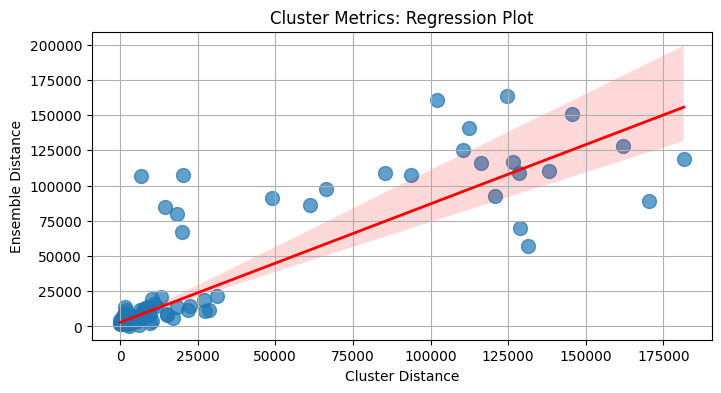

Correlation: 0.8560
P-value: 0.0000


In [349]:
from scipy.stats import pearsonr

data = merged_data[merged_data['label']=='1']
#data = merged_data[merged_data['dataset']=='telco']
#data = merged_data[(merged_data['dataset'] == 'telco') & (merged_data['label'] == 1)]
#data = merged_data

plt.figure(figsize=(8, 4))
sns.regplot(
    data=data,
    x='clusters_distances',
    y='ensembles_distances',
    scatter_kws={'s': 100, 'alpha': 0.7},  
    line_kws={'color': 'red', 'linewidth': 2},  
    robust=True
)

plt.title('Cluster Metrics: Regression Plot')
plt.xlabel('Cluster Distance')
plt.ylabel('Ensemble Distance')
plt.grid(True)
plt.show()

correlation, p_value = pearsonr(data['clusters_distances'], data['ensembles_distances'])
print(f'Correlation: {correlation:.4f}')
print(f'P-value: {p_value:.4f}')

#### Make 8 subplots for all combinations

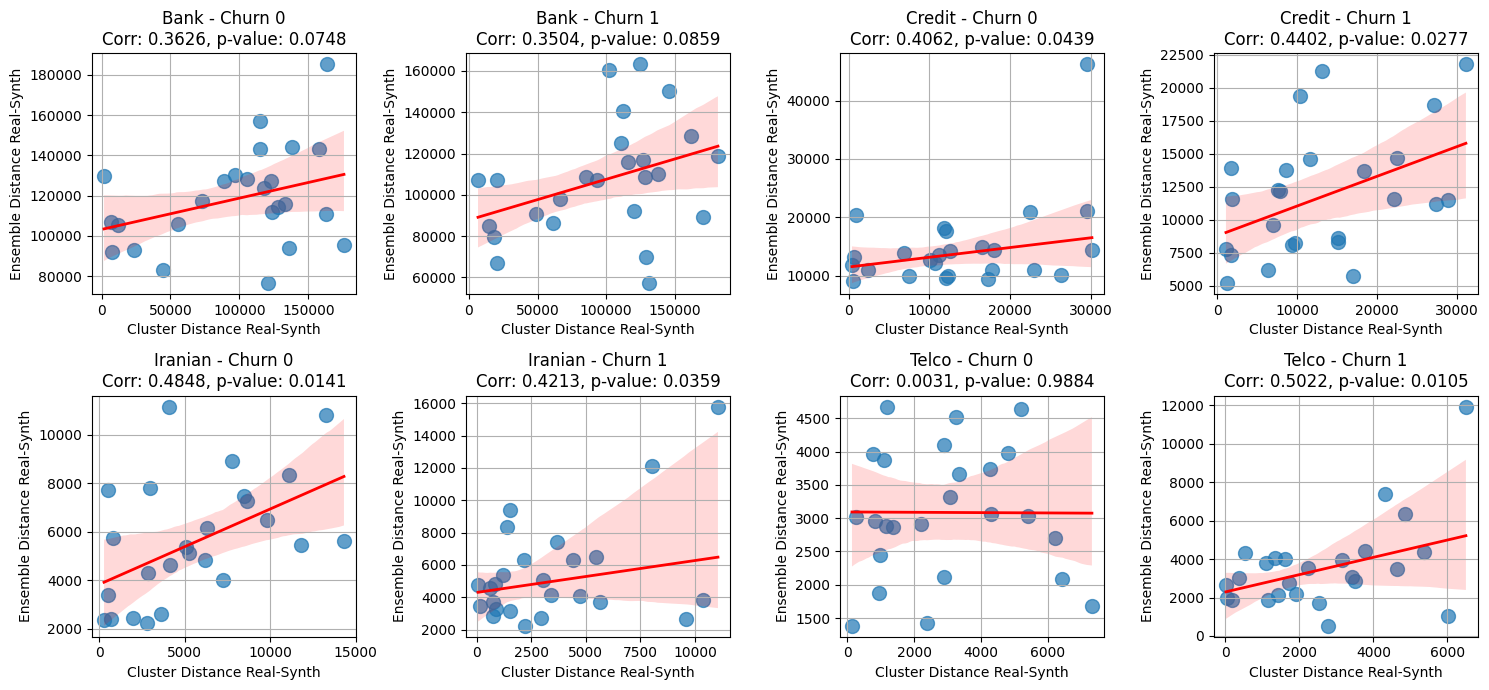

In [351]:
def plot_all_combinations(df):
    # Define all combinations of dataset and label
    datasets = df['dataset'].unique()  # Get unique dataset values
    labels = df['label'].unique()  # Get unique label values
    
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
    
    # Flatten the axes array to make iteration easier
    axes = axes.flatten()
    
    # Loop through all combinations of dataset and label
    plot_index = 0
    for dataset in datasets:
        for label in labels:
            # Filter data based on dataset and label
            filtered_data = df[(df['dataset'] == dataset) & (df['label'] == label)]
            
            # Calculate correlation and p-value for the filtered data
            correlation, p_value = pearsonr(filtered_data['clusters_distances'], filtered_data['ensembles_distances'])
            
            # Plot the regression plot on the current axis
            sns.regplot(
                data=filtered_data,
                x='clusters_distances',
                y='ensembles_distances',
                scatter_kws={'s': 100, 'alpha': 0.7},  
                line_kws={'color': 'red', 'linewidth': 2}, 
                robust=True,  
                ax=axes[plot_index]  # which the subplot
            )
            
            # title and labels for the subplot
            axes[plot_index].set_title(f'{dataset.capitalize()} - Churn {label}\nCorr: {correlation:.4f}, p-value: {p_value:.4f}')
            axes[plot_index].set_xlabel('Cluster Distance Real-Synth')
            axes[plot_index].set_ylabel('Ensemble Distance Real-Synth')
            axes[plot_index].grid(True)
            
            # Move to the next subplot
            plot_index += 1

    plt.tight_layout()
    plt.savefig("fig5_hierarc_new.pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_all_combinations(merged_data)
